In [1]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from imgaug import augmenters as iaa
import custom_augmentation as ciaa
import random

In [2]:
labels_file = json.loads(open(os.path.join('/home/linus/Desktop/data/combined.json'),'r').read())
print('Numbers of sample:', len(labels_file))

Numbers of sample: 13953


Tạo và kiểm tra path cho các ảnh trong dataset thuii.

In [3]:
for index, each_sample in tqdm(enumerate(labels_file), desc='Creating full path', total=len(labels_file)):
#     rgb_img_path = os.path.join(dataset_path, 'rgb', '{}_rgb.jpg'.format(each_sample['index']))
    rgb_img_path = each_sample['rgb_img_path']
    if not os.path.isfile(rgb_img_path):
        print(rgb_img_path, 'not exist. Skipped')
        labels_file.remove(each_sample)
        continue
#     depth_img_path = os.path.join(dataset_path, 'depth', '{}_rgb.jpg'.format(each_sample['index']))
    depth_img_path = each_sample['depth_img_path']
    if not os.path.isfile(depth_img_path):
        print(depth_img_path, 'not exist. Skipped')
        labels_file.remove(each_sample)
        continue
#     labels_file[index]['rgb_img_path'] = rgb_img_path
#     labels_file[index]['depth_img_path'] = depth_img_path

Creating full path: 100%|██████████| 13953/13953 [00:00<00:00, 223915.11it/s]


In [4]:
labels_file

[{'proximity value': True,
  'angle': -0.0,
  'rgb_img_path': '/home/linus/Desktop/data/dataset_1552725569.1256902/rgb/1_rgb.jpg',
  'index': 1,
  'speed': 0.0,
  'depth_img_path': '/home/linus/Desktop/data//dataset_1552725569.1256902/depth/1_depth.jpg'},
 {'proximity value': True,
  'angle': -0.0,
  'rgb_img_path': '/home/linus/Desktop/data/dataset_1552725569.1256902/rgb/2_rgb.jpg',
  'index': 2,
  'speed': 0.0,
  'depth_img_path': '/home/linus/Desktop/data//dataset_1552725569.1256902/depth/2_depth.jpg'},
 {'proximity value': True,
  'angle': -0.0,
  'rgb_img_path': '/home/linus/Desktop/data/dataset_1552725569.1256902/rgb/3_rgb.jpg',
  'index': 3,
  'speed': 0.0,
  'depth_img_path': '/home/linus/Desktop/data//dataset_1552725569.1256902/depth/3_depth.jpg'},
 {'proximity value': True,
  'angle': -0.0,
  'rgb_img_path': '/home/linus/Desktop/data/dataset_1552725569.1256902/rgb/4_rgb.jpg',
  'index': 4,
  'speed': 0.0,
  'depth_img_path': '/home/linus/Desktop/data//dataset_1552725569.12569

Augment để còn upsampling nhé

In [5]:
def show_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [6]:
augment_object = iaa.Sequential([
    iaa.Add((-20, 20)),
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.03*255)),
    iaa.Sometimes(0.5, iaa.MotionBlur(angle=(0, 360))),
    iaa.Sometimes(0.2, iaa.GammaContrast(gamma=(0.5, 1.44))),
    iaa.Sometimes(0.1, iaa.FastSnowyLandscape(lightness_threshold=(0, 150))),
    iaa.OneOf([
        iaa.Sometimes(0.8, ciaa.RandomShadow()),
        iaa.Sometimes(0.4, ciaa.RandomGravel()),
        iaa.Sometimes(0.2, ciaa.RandomSunFlare()),
        iaa.Sometimes(0.3, ciaa.RandomMotionBlur())
    ])
])

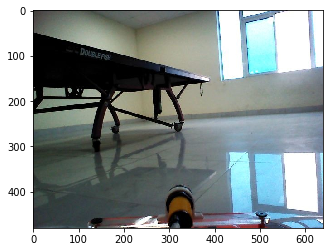

In [7]:
test_img = cv2.imread(random.choice(labels_file)['rgb_img_path'])
show_img(test_img)

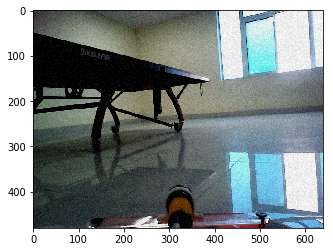

In [8]:
show_img(augment_object.augment_image(test_img))

Flip augmentation nè

-0.0


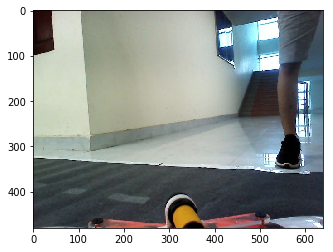

In [9]:
random_sample = random.choice(labels_file)
test_img = cv2.imread(random_sample['rgb_img_path'])
show_img(test_img)
print(random_sample['angle'])

0.0


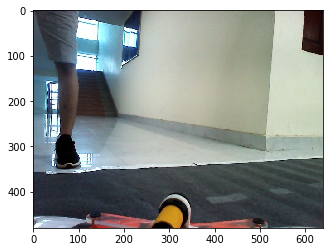

In [10]:
test_img_flip = cv2.flip(test_img, 1)
show_img(test_img_flip)
print(-random_sample['angle'])

In [11]:
def show_distribution(dataset, mode='angle'):
    list_temp = [each[mode] for each in dataset]
#     print(list_temp)
    plt.hist(list_temp)

Xem distribution của góc quay 

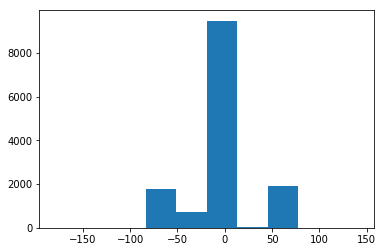

In [12]:
show_distribution(labels_file, 'angle')

Xem distribution của vận tốc

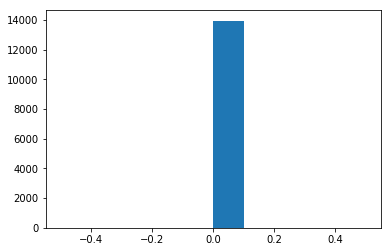

In [13]:
show_distribution(labels_file, 'speed')

Loại hết data khi xe đứng yên

Numbers of sample after remove stop: 13950


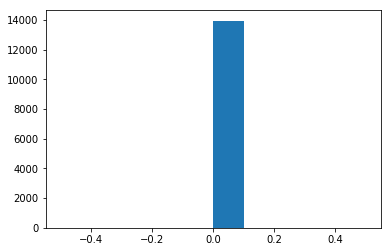

In [14]:
for index, each_sample in enumerate(labels_file):
    last_sample = [each_sample['speed'] for each_sample in labels_file[index-3:index]]
    if each_sample['speed']==0 and all(sample for sample in last_sample if sample==0):
        labels_file.remove(each_sample)
print('Numbers of sample after remove stop:', len(labels_file))
show_distribution(labels_file, 'speed')

Upsampling để cân distribution giữa các angle

In [17]:
left_range = (-150, 5)
right_range = (5, 150)

In [22]:
def calculate_angle_amount():
    global left, right, center
    left = right = center = 0
    for each_sample in labels_file:
        if each_sample['angle'] in range(left_range[0], left_range[1]):
            left += 1
        elif each_sample['angle'] in range(right_range[0], right_range[1]):
            right += 1
        else:
            center += 1
    print('Left: {} Right: {} Center: {}'.format(left, right, center))
calculate_angle_amount()

Left: 11827 Right: 1944 Center: 179


In [23]:
center/left

0.015134860911473747

In [24]:
center/right

0.09207818930041152

In [64]:
from IPython.display import clear_output

In [65]:
import multiprocessing

num_worker=12
pool = multiprocessing.Pool(num_worker)

def worker(output_index):
    global each_sample
    clear_output()
    old_path = each_sample['rgb_img_path']
    org_img = cv2.imread(old_path)            
    new_img = augment_object.augment_image(org_img)
    new_path = old_path.replace('.jpg','_{}.jpg'.format(output_index))
    cv2.imwrite(new_path, new_img)
    new_sample = {
        'index': each_sample['index'],
        'rgb_img_path': new_path,
        'depth_img_path': each_sample['depth_img_path'],
        'angle': each_sample['angle'],
        'speed': each_sample['speed']
    }
    return new_sample

Process ForkPoolWorker-151:
Process ForkPoolWorker-148:
Process ForkPoolWorker-145:
Process ForkPoolWorker-143:
Process ForkPoolWorker-152:
Process ForkPoolWorker-150:
Process ForkPoolWorker-149:
Process ForkPoolWorker-146:
Traceback (most recent call last):
Process ForkPoolWorker-147:
Traceback (most recent call last):
Process ForkPoolWorker-144:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-153:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last

  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 540, in augment_images
    hooks=hooks
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 452, in augment_images
    hooks=hooks
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 452, in augment_images
    hooks=hooks
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 540, in augment_images
    hooks=hooks
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 1963, in _augment_images
    hooks=hooks
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 1963, in _augment_images
    hooks=hooks
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 540, in augment_images
    hooks=hooks
  File "/hom

  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/parameters.py", line 288, in draw_samples
    random_state)
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 1963, in _augment_images
    hooks=hooks
  File "/home/linus/model_notTrashCar/custom_augmentation.py", line 98, in _augment_images
    result[_idx] = am.add_gravel(image)
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/parameters.py", line 748, in _draw_samples
    return random_state.normal(loc, scale, size=size)
  File "/home/linus/model_notTrashCar/automold.py", line 548, in add_gravel
    output= gravel_process(image,x1,x2,y1,y2,no_of_patches)
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 452, in augment_images
    hooks=hooks
KeyboardInterrupt
  File "/home/linus/.local/lib/python3.6/site-packages/imgaug/augmenters/meta.py", line 452, in augment_images
    hooks=hooks
  File "/home/linus/model_notTrashCar/automold.py",

In [66]:
def augment_duplicate_upsampling(dataset, src_amount, dst_amount, angle_range):
    global each_sample
    new_sample_list = []
    if dst_amount/src_amount < 2:
        percent_need_upsample = int(((dst_amount-src_amount)/2)/src_amount * 100)
        multiplier = 1
    else:
        percent_need_upsample = 101
        multiplier = (dst_amount // src_amount) - 1
    for index, each_sample in tqdm(enumerate(dataset), total=len(dataset)):
        if each_sample['angle'] >= angle_range[0] and each_sample['angle'] <= angle_range[1] and random.randint(0, 100) <= percent_need_upsample:
            output_index = list(range(multiplier))
            new_sample_list = list(pool.imap(worker, output_index))
    final_data = new_sample_list + dataset
    print("Numbers of sample after upsampling: ", len(final_data))
    calculate_angle_amount()
    return final_data

In [67]:
def augment_flip_image(dataset, src_amount, dst_amount, angle_range):
    new_sample_list = []
    if dst_amount/src_amount < 2:
        percent_need_upsample = int(((dst_amount-src_amount)/2)/src_amount * 100)
        multiplier = 1
    else:
        percent_need_upsample = 101
        multiplier = (dst_amount // src_amount) - 1
    for index, each_sample in tqdm(enumerate(dataset), total=len(dataset)):
        if each_sample['angle'] >= angle_range[0] and each_sample['angle'] <= angle_range[1] and random.randint(0, 100) <= percent_need_upsample:
            for output_index in range(multiplier):
                old_rgb_path = each_sample['rgb_img_path']
                org_rgb_img = cv2.imread(old_rgb_path)            
                new_rgb_img = cv2.flip(org_rgb_img, 1)
                new_rgb_path = old_rgb_path.replace('.jpg','_{}.jpg'.format(output_index))
                cv2.imwrite(new_rgb_path, new_rgb_img)
                old_depth_path = each_sample['depth_img_path']
                org_depth_img = cv2.imread(old_depth_path)            
                new_depth_img = cv2.flip(org_depth_img, 1)
                new_depth_path = old_depth_path.replace('.jpg','_{}.jpg'.format(output_index))
                cv2.imwrite(new_depth_path, new_depth_img)
                new_sample = {
                    'index': each_sample['index'],
                    'rgb_img_path': new_rgb_path,
                    'depth_img_path': new_depth_path,
                    'angle': -each_sample['angle'],
                    'speed': each_sample['speed']
                }
                new_sample_list.append(new_sample)
    final_data = new_sample_list + dataset
    print("Numbers of sample after upsampling: ", len(final_data))
    calculate_angle_amount()
    return final_data 

In [68]:
labels_file = augment_duplicate_upsampling(labels_file, center, left, (-5,5))
show_distribution(labels_file, 'angle')










  0%|          | 0/13950 [00:00<?, ?it/s]








  0%|          | 1/13950 [00:01<4:26:19,  1.15s/it]








  0%|          | 2/13950 [00:02<4:09:36,  1.07s/it]








  0%|          | 3/13950 [00:02<3:57:15,  1.02s/it]








  0%|          | 4/13950 [00:03<3:50:10,  1.01it/s]








  0%|          | 5/13950 [00:04<3:22:23,  1.15it/s]








  0%|          | 6/13950 [00:05<3:25:47,  1.13it/s]








  0%|          | 7/13950 [00:05<3:04:46,  1.26it/s]








  0%|          | 8/13950 [00:06<2:52:22,  1.35it/s]








  0%|          | 9/13950 [00:07<3:05:36,  1.25it/s]








  0%|          | 10/13950 [00:08<3:19:39,  1.16it/s]








  0%|          | 11/13950 [00:09<3:16:22,  1.18it/s]








  0%|          | 12/13950 [00:09<3:02:42,  1.27it/s]








  0%|          | 13/13950 [00:11<3:22:11,  1.15it/s]








  0%|          | 14/13950 [00:11<3:22:44,  1.15it/s]








  0%|          | 15/13950 [00:12<3:17:30,  1.18it/s]








  0%|          | 16/13950 [00:13<2:

  1%|          | 93/13950 [01:19<3:42:53,  1.04it/s]








  1%|          | 94/13950 [01:20<3:52:10,  1.01s/it]








  1%|          | 95/13950 [01:21<3:40:33,  1.05it/s]








  1%|          | 96/13950 [01:22<4:00:30,  1.04s/it]








  1%|          | 97/13950 [01:23<4:04:40,  1.06s/it]








  1%|          | 98/13950 [01:24<3:59:22,  1.04s/it]








  1%|          | 99/13950 [01:25<3:35:07,  1.07it/s]








  1%|          | 100/13950 [01:26<3:26:15,  1.12it/s]








  1%|          | 101/13950 [01:27<3:22:43,  1.14it/s]








  1%|          | 102/13950 [01:27<3:19:02,  1.16it/s]








  1%|          | 103/13950 [01:28<3:16:28,  1.17it/s]








  1%|          | 104/13950 [01:29<3:12:01,  1.20it/s]








  1%|          | 105/13950 [01:30<3:08:50,  1.22it/s]








  1%|          | 106/13950 [01:31<3:06:06,  1.24it/s]








  1%|          | 107/13950 [01:32<3:23:37,  1.13it/s]








  1%|          | 108/13950 [01:32<3:16:24,  1.17it/s]








  1%|          

  1%|▏         | 185/13950 [02:39<2:59:05,  1.28it/s]








  1%|▏         | 186/13950 [02:40<2:54:22,  1.32it/s]








  1%|▏         | 187/13950 [02:40<2:50:55,  1.34it/s]








  1%|▏         | 188/13950 [02:41<3:03:16,  1.25it/s]








  1%|▏         | 189/13950 [02:42<3:22:20,  1.13it/s]








  1%|▏         | 190/13950 [02:43<3:21:56,  1.14it/s]








  1%|▏         | 191/13950 [02:44<3:13:02,  1.19it/s]








  1%|▏         | 192/13950 [02:45<3:17:40,  1.16it/s]








  1%|▏         | 193/13950 [02:46<3:20:20,  1.14it/s]








  1%|▏         | 194/13950 [02:46<3:08:21,  1.22it/s]








  1%|▏         | 202/13950 [02:47<2:18:51,  1.65it/s]








  1%|▏         | 203/13950 [02:48<2:27:00,  1.56it/s]








  1%|▏         | 204/13950 [02:49<2:45:51,  1.38it/s]








  1%|▏         | 205/13950 [02:50<2:55:27,  1.31it/s]








  1%|▏         | 206/13950 [02:51<3:03:06,  1.25it/s]








  1%|▏         | 207/13950 [02:51<3:00:17,  1.27it/s]








  1%|▏  

  2%|▏         | 290/13950 [03:56<2:07:44,  1.78it/s]








  2%|▏         | 291/13950 [03:56<2:11:59,  1.72it/s]








  2%|▏         | 292/13950 [03:57<2:27:44,  1.54it/s]








  2%|▏         | 293/13950 [03:58<2:26:50,  1.55it/s]








  2%|▏         | 294/13950 [03:58<2:18:18,  1.65it/s]








  2%|▏         | 295/13950 [03:59<2:09:56,  1.75it/s]








  2%|▏         | 296/13950 [03:59<2:05:18,  1.82it/s]








  2%|▏         | 297/13950 [04:00<2:14:54,  1.69it/s]








  2%|▏         | 298/13950 [04:02<4:08:16,  1.09s/it]








  2%|▏         | 299/13950 [04:03<3:37:12,  1.05it/s]








  2%|▏         | 300/13950 [04:04<3:20:18,  1.14it/s]








  2%|▏         | 301/13950 [04:04<3:05:20,  1.23it/s]








  2%|▏         | 302/13950 [04:06<3:57:58,  1.05s/it]








  2%|▏         | 303/13950 [04:07<4:31:59,  1.20s/it]








  2%|▏         | 304/13950 [04:08<4:04:12,  1.07s/it]








  2%|▏         | 305/13950 [04:09<3:26:31,  1.10it/s]








  2%|▏  

  4%|▎         | 507/13950 [05:16<2:27:44,  1.52it/s]








  4%|▎         | 508/13950 [05:16<2:42:02,  1.38it/s]








  4%|▎         | 509/13950 [05:17<2:57:33,  1.26it/s]








  4%|▎         | 510/13950 [05:18<3:07:35,  1.19it/s]








  4%|▎         | 511/13950 [05:19<3:06:37,  1.20it/s]








  4%|▎         | 512/13950 [05:20<3:06:19,  1.20it/s]








  4%|▎         | 513/13950 [05:21<3:12:02,  1.17it/s]








  4%|▎         | 514/13950 [05:22<3:15:12,  1.15it/s]








  4%|▎         | 515/13950 [05:23<3:08:09,  1.19it/s]








  4%|▎         | 516/13950 [05:23<2:56:44,  1.27it/s]








  4%|▎         | 517/13950 [05:24<2:54:49,  1.28it/s]








  4%|▎         | 518/13950 [05:25<2:51:32,  1.31it/s]








  4%|▎         | 519/13950 [05:26<3:22:28,  1.11it/s]








  4%|▎         | 520/13950 [05:27<3:17:31,  1.13it/s]








  4%|▎         | 521/13950 [05:28<3:32:50,  1.05it/s]








  4%|▎         | 522/13950 [05:29<3:39:22,  1.02it/s]








  4%|▎  

  4%|▍         | 604/13950 [06:32<3:21:31,  1.10it/s]








  4%|▍         | 605/13950 [06:33<3:14:54,  1.14it/s]








  4%|▍         | 606/13950 [06:34<3:10:15,  1.17it/s]








  4%|▍         | 607/13950 [06:35<3:39:34,  1.01it/s]








  4%|▍         | 608/13950 [06:36<3:39:20,  1.01it/s]








  4%|▍         | 609/13950 [06:37<3:34:45,  1.04it/s]








  4%|▍         | 610/13950 [06:38<3:27:43,  1.07it/s]








  4%|▍         | 611/13950 [06:39<3:36:40,  1.03it/s]








  4%|▍         | 612/13950 [06:40<3:26:45,  1.08it/s]








  4%|▍         | 613/13950 [06:41<3:15:54,  1.13it/s]








  4%|▍         | 614/13950 [06:41<3:06:46,  1.19it/s]








  4%|▍         | 615/13950 [06:42<3:02:04,  1.22it/s]








  4%|▍         | 616/13950 [06:43<3:10:20,  1.17it/s]








  4%|▍         | 617/13950 [06:44<3:15:39,  1.14it/s]








  4%|▍         | 618/13950 [06:45<3:43:07,  1.00s/it]








  4%|▍         | 619/13950 [06:46<3:46:18,  1.02s/it]








  4%|▍  

  5%|▍         | 696/13950 [07:53<3:03:55,  1.20it/s]








  5%|▍         | 697/13950 [07:54<3:02:45,  1.21it/s]








  5%|▌         | 698/13950 [07:55<3:06:21,  1.19it/s]








  5%|▌         | 699/13950 [07:56<3:01:30,  1.22it/s]








  5%|▌         | 700/13950 [07:57<3:09:39,  1.16it/s]








  5%|▌         | 701/13950 [07:57<3:07:34,  1.18it/s]








  5%|▌         | 702/13950 [07:58<3:01:17,  1.22it/s]








  5%|▌         | 703/13950 [07:59<2:56:45,  1.25it/s]








  5%|▌         | 704/13950 [08:00<3:05:09,  1.19it/s]








  5%|▌         | 705/13950 [08:01<3:15:10,  1.13it/s]








  5%|▌         | 706/13950 [08:02<3:41:01,  1.00s/it]








  5%|▌         | 707/13950 [08:03<3:29:13,  1.05it/s]








  5%|▌         | 708/13950 [08:04<3:32:50,  1.04it/s]








  5%|▌         | 709/13950 [08:05<3:32:28,  1.04it/s]








  5%|▌         | 710/13950 [08:06<3:33:33,  1.03it/s]








  5%|▌         | 711/13950 [08:07<3:26:25,  1.07it/s]








  5%|▌  

KeyboardInterrupt: 

In [ ]:
labels_file = augment_duplicate_upsampling(labels_file, center, center, left_range)
show_distribution(labels_file, 'angle')

In [ ]:
with open(os.path.join(dataset_path, 'over_sampled_label.json'), 'w', encoding='utf-8') as outfile:
    json.dump(labels_file, outfile, ensure_ascii=False, sort_keys=False, indent=4)
    outfile.write("\n")